In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings("ignore")

In [5]:

# 1).ARIMA/Sarima與LSTM的時間序列數據集成學習（附連結） 原文網址：https://kknews.cc/tech/9gq96v8.html
# 2). 使用LSTM模型預測股價基於Keras (https://kknews.cc/zh-tw/finance/n6962xg.html)

# Collect TMS , 2020/1/1 以後所有module的GC/GE類上下機資料 
# 針對 更換量/機台 比 > 60 的Parts 
# 1. 進行AI訓鍊(2020/1~2020/12)&驗證(2021/1~2021/4 or 2021Q1) . 統計 Model & Avg 的準確度
# 2. 統計其庫存金額占比

In [6]:
df_AllParts = pd.read_csv('./Over_60_Ratio_Parts/Over_60_Ratio_Parts_Monthly_Data.csv',encoding="big5hkscs" )
# list_Parts = df_AllParts['PART_NO'].unique().tolist()
# df_list = pd.DataFrame(list_Parts)
# df_list.to_csv('./data/PartsList.csv' , index = False)
# df_AllParts.info()

<AxesSubplot:xlabel='STOCK_EVENT_TIME'>

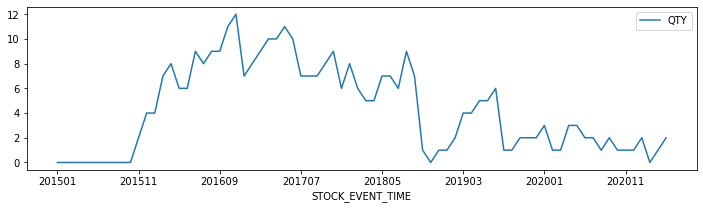

In [7]:
# PartNO = 85-ECT1190 ,85-ECT1200,85-EWA1080,85-ENH0300

PartNO = '85-ENH0300'

df_85ECT= df_AllParts[(df_AllParts.PART_NO == PartNO)]
# 移除MFG_MONTH ,此處的MFG_MONTH指的是使用哪個時間點的時間的資料去增量機台相關資料
df_85ECT = df_85ECT[['STOCK_EVENT_TIME','PART_NO','EQP_NO','QTY']]
df_85ECT_SUM = df_85ECT[['STOCK_EVENT_TIME','QTY']]
# df_85ECT_SUM = df_85ECT_SUM.set_index('STOCK_EVENT_TIME').groupby('STOCK_EVENT_TIME').sum('QTY')
df_85ECT_SUM['STOCK_EVENT_TIME'] =df_85ECT_SUM['STOCK_EVENT_TIME'].astype(str)
df_85ECT_SUM = df_85ECT_SUM.groupby('STOCK_EVENT_TIME').sum('QTY')
df_85ECT_SUM.plot(figsize=(12,3))
# df_85ECT.info()
# df_85ECT_SUM

In [8]:
df_85ECT

,STOCK_EVENT_TIME,PART_NO,EQP_NO,QTY
53732,201501,85-ENH0300,EGH03,0.0
53733,201502,85-ENH0300,EGH03,0.0
53734,201503,85-ENH0300,EGH03,0.0
53735,201504,85-ENH0300,EGH03,0.0
53736,201505,85-ENH0300,EGH03,0.0
...,...,...,...,...
53955,202012,85-ENH0300,ENH02,0.0
53956,202101,85-ENH0300,ENH02,0.0
53957,202102,85-ENH0300,ENH02,0.0
53958,202103,85-ENH0300,ENH02,0.0


In [9]:
look_back =1

def getData():
    df = df_85ECT    
    df = df.rename(columns={'STOCK_EVENT_TIME':'MFG_MONTH'})
    df['MFG_MONTH'] =df['MFG_MONTH'].astype(str)
    df = df.groupby(['MFG_MONTH']).sum('QTY')
    df = df.sort_values(by=['MFG_MONTH'], ascending=[True])
    df = df.reset_index()
    return df[df['MFG_MONTH']<='202012']  ,df[df['MFG_MONTH']>='202101'] 

In [10]:
# getData()

In [11]:
# getData()
# 取得 訓練集 和 測試級 資料
train ,test = getData() 
print("train :",train.shape, " test :",test.shape) 

train : (72, 2)  test : (4, 2)


In [12]:
train.shape[0]
test.shape[0]

4

In [13]:
# X is the number of passengers at a given time (t) and Y is the number of passengers at the next time (t + 1).
# 特徵縮放 :正規化(normalize) 資料，使資料值介於[0, 1]
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))

# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
    dataset = dataset.iloc[:, 1:2].values    
    scaler_data = scaler.fit_transform(dataset)
    dataX, dataY = [], []   
    for i in range(look_back,dataset.shape[0]):    
        dataX.append(scaler_data[i-look_back:i, 0]) 
        dataY.append(scaler_data[i, 0])
    return np.array(dataX), np.array(dataY)

In [14]:
# create_dataset(test, look_back)

In [15]:
# X=t and Y=t+1 时的数据，并且此时的维度为 [samples, features]
# 投入到 LSTM 的 X 需要有这样的结构： [samples, time steps, features] 
trainX, trainY = create_dataset(train, look_back)
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))


# reshape input to be [samples, time steps, features]
# testX, testY = create_dataset(test, look_back)
# testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

#取測試集   
actual_test_qty = test['QTY'].iloc[:].values  # 實際使用量
dataset_total = pd.concat((train['QTY'], test['QTY']), axis = 0)
inputs = dataset_total[len(dataset_total) - len(test) - look_back:].values
inputs = inputs.reshape(-1,1)
inputs = scaler.transform(inputs)
testX , testY = [], []   
for i in range(look_back, inputs.shape[0]):
    testX.append(inputs[i-look_back:i, 0])
    testY.append(inputs[i, 0])
testX = np.array(testX)
testY = np.array(testY)
testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1))


In [16]:
# print(train.shape[0])
# print(test.shape[0])
# print(trainX.shape[0])
print(testX.shape[0])


4


In [17]:
def visualize(history):
    print(history.history.keys())
    plt.rcParams['figure.figsize'] = (6.0, 5.0)
    # Plot training & validation loss values
    plt.plot(history.history['loss'])
    plt.plot(history.history['mse'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['loss', 'mse'], loc='upper left')
    plt.show()


Train on 71 samples
Epoch 1/50
71/71 - 3s - loss: 0.1534 - mse: 0.1534
Epoch 2/50
71/71 - 0s - loss: 0.1088 - mse: 0.1088
Epoch 3/50
71/71 - 0s - loss: 0.0838 - mse: 0.0838
Epoch 4/50
71/71 - 0s - loss: 0.0658 - mse: 0.0658
Epoch 5/50
71/71 - 0s - loss: 0.0735 - mse: 0.0735
Epoch 6/50
71/71 - 0s - loss: 0.0686 - mse: 0.0686
Epoch 7/50
71/71 - 0s - loss: 0.0635 - mse: 0.0635
Epoch 8/50
71/71 - 0s - loss: 0.0709 - mse: 0.0709
Epoch 9/50
71/71 - 0s - loss: 0.0641 - mse: 0.0641
Epoch 10/50
71/71 - 0s - loss: 0.0561 - mse: 0.0561
Epoch 11/50
71/71 - 0s - loss: 0.0526 - mse: 0.0526
Epoch 12/50
71/71 - 0s - loss: 0.0766 - mse: 0.0766
Epoch 13/50
71/71 - 0s - loss: 0.0445 - mse: 0.0445
Epoch 14/50
71/71 - 0s - loss: 0.0407 - mse: 0.0407
Epoch 15/50
71/71 - 0s - loss: 0.0437 - mse: 0.0437
Epoch 16/50
71/71 - 0s - loss: 0.0317 - mse: 0.0317
Epoch 17/50
71/71 - 0s - loss: 0.0572 - mse: 0.0572
Epoch 18/50
71/71 - 0s - loss: 0.0420 - mse: 0.0420
Epoch 19/50
71/71 - 0s - loss: 0.0413 - mse: 0.0413
E

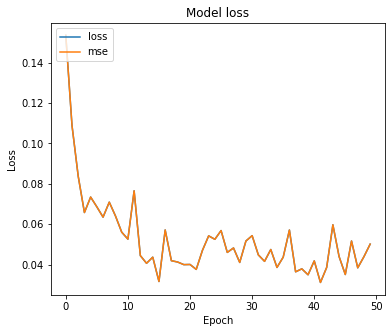

In [18]:
#Building the RNN
#Importing the tensorflow libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout


#.建立及訓練 LSTM 模型，一個LSTM層及output層
# 輸入層有 1個input，隱藏曾有4個神經元，輸出層就是預測1個值，激活函数用 sigmoid，迭代 50 次，batch size為1
model = Sequential()
# model.add(LSTM(4, activation='relu', input_shape=(1, look_back)))
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dropout(rate = 0.2))
model.add(Dense(1))
# metrics = ['mse', 'mae', 'mape'] optimizer = tf.keras.optimizers.Adam(0.001)
model.compile(loss='mean_squared_error', optimizer = tf.keras.optimizers.Adam(0.001), metrics = ['mse'])
history_lstm_model = model.fit(trainX, trainY, epochs=50,  batch_size=1,verbose=2)
visualize(history_lstm_model)
print(model.summary())
# 為了防止過擬合，我們添加了LSTM層和Dropout層，其中LSTM層的參數如下：
# 在定義Dropout層時，我們指定參數為0.2，意味著將刪除20%的層。然後，我們指定1個單元的輸出作為全連接層（Dense layer）。接著，我們使用目前流行的adam優化器編譯模型，並用均方誤差（mean_squarred_error）來計算誤差。

# 原文網址：https://kknews.cc/finance/n6962xg.html


In [19]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

In [20]:
# 计算误差之前要先把预测数据转换成同一单位
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
# testPredict值 四捨五入
testPredict = np.round(scaler.inverse_transform(testPredict)) 
testY = scaler.inverse_transform([testY])

# # 计算 mean squared error
# trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
# print('Train Score: %.2f RMSE' % (trainScore))
# testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
# print('Test Score: %.2f RMSE' % (testScore))



In [21]:
# len(actual_test_qty)
len(testPredict)

4

In [22]:
test['Predict']=testPredict
test

,MFG_MONTH,QTY,Predict
72,202101,2.0,2.0
73,202102,0.0,3.0
74,202103,1.0,2.0
75,202104,2.0,2.0


In [23]:
def accsum(def_result,target_cols):
        _accsum=0 
        for index,row in def_result.iterrows():
            #避免當分母為0 會無法計算
            if row[target_cols]==0 and row['Predict']==0 :
                row[target_cols] =1
                row['Predict'] =1
            elif row[target_cols] ==0 and row['Predict']!=0:
                row[target_cols]  =0.00001

            if row[target_cols] <0 :
                row[target_cols]  =0.00001

            if row['Predict'] <0 :
                row['Predict']  =0 

            if 1- abs((row['Predict'] - row[target_cols])/row[target_cols] ) >0 : 
                _accsum+=(1- abs((row['Predict'] - row[target_cols])/row[target_cols] ))
        
        return round(_accsum*100/def_result.shape[0],2)

In [24]:
# 計算by 月 & 季準確率
_score_month =0
actual_test_qty = test['QTY'].iloc[:].values  # 實際使用量
test['Predict']=testPredict
_score_month = accsum(test,'QTY')


_score_quarter =0
df_Quarter = test
df_Quarter['NewDate']=  test['MFG_MONTH']+"01"
df_Quarter['NewDate'] =  pd.to_datetime(df_Quarter['NewDate']).dt.strftime('%Y-%m-%d')
df_Quarter['NewDate']=  pd.to_datetime(df_Quarter['NewDate'])
df_Quarter = df_Quarter.drop(columns=['MFG_MONTH']) 

df_Quarter =  df_Quarter.set_index('NewDate').resample('Q').sum().reset_index()
_score_quarter = accsum(df_Quarter,'QTY')


print('PART_NO:',PartNO)
print(f'準確率(月): {_score_month}')
print(f'準確率(季): {_score_quarter}')


PART_NO: 85-ENH0300
準確率(月): 50.0
準確率(季): 50.0


In [25]:
print(actual_test_qty)
print(testPredict.reshape(-1))

[2. 0. 1. 2.]
[2. 3. 2. 2.]


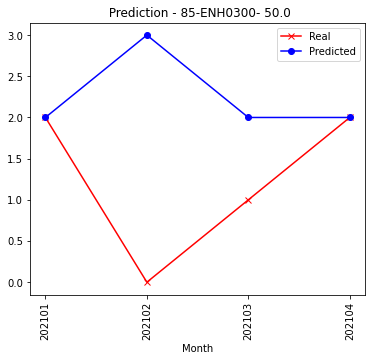

In [26]:
t = test['MFG_MONTH'].astype(str).to_numpy() 
plt.plot(t,actual_test_qty, color = 'red', label = 'Real',marker='x')
plt.plot(t,testPredict, color = 'blue', label = 'Predicted',marker= 'o')
plt.title(' Prediction - {0}- {1}'.format(PartNO,_score_month))
plt.xlabel('Month')
plt.xticks(rotation=90)    
# plt.ylabel('Google Stock Price')
plt.legend()
plt.show()

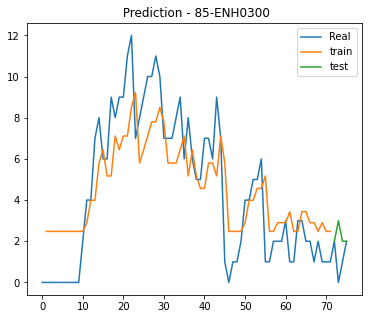

In [27]:
# 畫訓練資料趨勢圖
# shift train predictions for plotting

dataset_total = dataset_total.values.reshape(-1,1)
trainPredictPlot = np.empty_like(dataset_total, dtype=float)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# trainPredictPlot
# 畫測試資料趨勢圖
# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset_total, dtype=float)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back):len(dataset_total), :] = testPredict

# 畫原始資料趨勢圖
# plot baseline and predictions
# plt.plot(scaler.inverse_transform(inputs))
# plt.title(' Prediction - {0} - {1} - {2}'.format(PARTNO,_score_month,_score))
plt.title(' Prediction - {0}'.format(PartNO))
plt.plot(dataset_total, label = 'Real')
plt.plot(trainPredictPlot ,label = 'train')
plt.plot(testPredictPlot, label = 'test')
plt.legend()
plt.show()